In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 656.5803, train_label_loss: 2.8174, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 10693.2313, train_label_loss: 2.6664, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 10808.6317, train_label_loss: 2.6441, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 10780.3966, train_label_loss: 2.4772, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 10752.3763, train_label_loss: 2.3638, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 10816.1303, train_label_loss: 2.2743, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 10754.4564, train_label_loss: 2.1296, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 10762.2375, train_label_loss: 1.8910, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 10730.0298, train_label_loss: 1.7669, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 10653.1427, train_label_loss: 1.6328, 


epoch: 1, source_val_acc_label: 0.5788, source_val_label_loss: 1.4578, target_val_acc_label: 0.5344, target_val_label_loss: 1.5411, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 48.9238, train_label_loss: 1.6356, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 10555.8635, train_label_loss: 1.2942, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 10675.9856, train_label_loss: 1.3902, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 10636.8107, train_label_loss: 1.3572, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 10663.6048, train_label_loss: 1.1235, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 10817.3943, train_label_loss: 0.9907, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 10684.7258, train_label_loss: 1.0573, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 10536.0931, train_label_loss: 0.8958, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 10661.9847, train_label_loss: 0.8719, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 10692.6268, train_label_loss: 0.7316, 


epoch: 2, source_val_acc_label: 0.8067, source_val_label_loss: 0.7057, target_val_acc_label: 0.7257, target_val_label_loss: 0.9071, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 57.5872, train_label_loss: 0.5882, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 10726.3015, train_label_loss: 0.6370, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 10666.0396, train_label_loss: 0.6446, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 10587.9437, train_label_loss: 0.5146, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 10710.8614, train_label_loss: 0.4999, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11538.7197, train_label_loss: 0.5472, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11824.3422, train_label_loss: 0.4903, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11589.6445, train_label_loss: 0.5118, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11472.9963, train_label_loss: 0.4893, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11732.5881, train_label_loss: 0.3724, 


epoch: 3, source_val_acc_label: 0.9075, source_val_label_loss: 0.3814, target_val_acc_label: 0.8046, target_val_label_loss: 0.6352, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 64.1492, train_label_loss: 0.4178, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11472.8740, train_label_loss: 0.3936, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11567.7550, train_label_loss: 0.3644, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 11735.4861, train_label_loss: 0.3963, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 11534.5230, train_label_loss: 0.3687, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11715.5257, train_label_loss: 0.3404, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11784.8119, train_label_loss: 0.3432, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11766.9489, train_label_loss: 0.3695, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11768.2128, train_label_loss: 0.2674, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11811.1310, train_label_loss: 0.3175, 


epoch: 4, source_val_acc_label: 0.9019, source_val_label_loss: 0.3411, target_val_acc_label: 0.8047, target_val_label_loss: 0.6350, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 64.6885, train_label_loss: 0.2437, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11813.7195, train_label_loss: 0.3203, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11671.9767, train_label_loss: 0.2092, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11738.1161, train_label_loss: 0.2653, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11805.0872, train_label_loss: 0.2410, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 12073.7533, train_label_loss: 0.3191, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11916.4581, train_label_loss: 0.1791, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11824.8054, train_label_loss: 0.2231, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11712.6156, train_label_loss: 0.2393, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11779.9912, train_label_loss: 0.2356, 


epoch: 5, source_val_acc_label: 0.9267, source_val_label_loss: 0.2644, target_val_acc_label: 0.8215, target_val_label_loss: 0.5834, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 64.5197, train_label_loss: 0.2665, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11820.0629, train_label_loss: 0.2407, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11773.9423, train_label_loss: 0.1934, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11769.6244, train_label_loss: 0.2436, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11761.7692, train_label_loss: 0.2708, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11754.0660, train_label_loss: 0.3063, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11769.5378, train_label_loss: 0.2065, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11836.4476, train_label_loss: 0.4229, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11780.8258, train_label_loss: 0.1654, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11765.6504, train_label_loss: 0.2186, 


epoch: 6, source_val_acc_label: 0.9424, source_val_label_loss: 0.2195, target_val_acc_label: 0.8494, target_val_label_loss: 0.5120, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 64.1528, train_label_loss: 0.2528, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11755.9448, train_label_loss: 0.1647, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11707.9651, train_label_loss: 0.3114, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11759.5205, train_label_loss: 0.1873, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 12252.3555, train_label_loss: 0.1591, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 12659.1985, train_label_loss: 0.2103, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 12597.6418, train_label_loss: 0.1475, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 12509.7141, train_label_loss: 0.2650, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11108.8785, train_label_loss: 0.1907, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 10767.6091, train_label_loss: 0.1953, 


epoch: 7, source_val_acc_label: 0.9441, source_val_label_loss: 0.1925, target_val_acc_label: 0.8381, target_val_label_loss: 0.5951, 


epoch: 8, [batch: 1 / 1400], examples_per_second: 57.3513, train_label_loss: 0.1634, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 10657.0533, train_label_loss: 0.2016, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 10742.1171, train_label_loss: 0.2847, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 10731.4132, train_label_loss: 0.1625, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 10790.1125, train_label_loss: 0.1385, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 10614.3674, train_label_loss: 0.1663, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 10738.9800, train_label_loss: 0.1364, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 10757.8027, train_label_loss: 0.1952, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 10728.5978, train_label_loss: 0.1700, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 10637.2653, train_label_loss: 0.1699, 


epoch: 8, source_val_acc_label: 0.9382, source_val_label_loss: 0.5102, target_val_acc_label: 0.8353, target_val_label_loss: 0.5830, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 56.9741, train_label_loss: 0.1804, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 10656.4157, train_label_loss: 0.2342, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 10697.4556, train_label_loss: 0.2204, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 10805.2909, train_label_loss: 0.1641, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 10710.4844, train_label_loss: 0.1514, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 10718.4160, train_label_loss: 0.1928, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 10741.8884, train_label_loss: 0.2033, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 10703.3662, train_label_loss: 0.3592, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 10629.2880, train_label_loss: 0.1524, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 10732.9303, train_label_loss: 0.1681, 


epoch: 9, source_val_acc_label: 0.9395, source_val_label_loss: 0.2438, target_val_acc_label: 0.8563, target_val_label_loss: 0.7839, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 56.4016, train_label_loss: 0.2121, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 10728.1180, train_label_loss: 0.1396, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 10072.9395, train_label_loss: 0.1848, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 10740.5882, train_label_loss: 0.1354, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 10783.2285, train_label_loss: 0.1264, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 10716.1115, train_label_loss: 0.1497, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 10730.2964, train_label_loss: 0.0700, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 10769.1642, train_label_loss: 0.1530, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 10769.2537, train_label_loss: 0.2516, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 10732.9886, train_label_loss: 0.1709, 


epoch: 10, source_val_acc_label: 0.9524, source_val_label_loss: 0.1516, target_val_acc_label: 0.8502, target_val_label_loss: 0.5904, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 57.1731, train_label_loss: 0.1249, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 10619.5187, train_label_loss: 0.1314, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 10702.1440, train_label_loss: 0.1332, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 10671.0519, train_label_loss: 0.2633, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 10719.9050, train_label_loss: 0.1609, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 10696.3169, train_label_loss: 0.1495, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 10668.5664, train_label_loss: 0.1378, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 10809.4913, train_label_loss: 0.1026, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 10737.4535, train_label_loss: 0.1650, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 10779.2262, train_label_loss: 0.0946, 


epoch: 11, source_val_acc_label: 0.9570, source_val_label_loss: 0.3312, target_val_acc_label: 0.8598, target_val_label_loss: 1.2955, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 56.6686, train_label_loss: 0.1032, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 10733.0447, train_label_loss: 0.2257, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 10798.0570, train_label_loss: 0.1735, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 10698.4956, train_label_loss: 0.1793, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 10699.0347, train_label_loss: 0.1954, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 10725.7976, train_label_loss: 0.1412, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 10664.8334, train_label_loss: 0.1045, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 10680.0314, train_label_loss: 0.1065, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 10637.9639, train_label_loss: 0.1031, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 10832.2921, train_label_loss: 0.0640, 


epoch: 12, source_val_acc_label: 0.9484, source_val_label_loss: 0.2119, target_val_acc_label: 0.8478, target_val_label_loss: 0.5593, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 58.4261, train_label_loss: 0.1342, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 10717.6807, train_label_loss: 0.0743, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 10672.9748, train_label_loss: 0.1232, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 10724.7921, train_label_loss: 0.1410, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 10748.1449, train_label_loss: 0.1195, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 10745.7124, train_label_loss: 0.0675, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 10755.7460, train_label_loss: 0.1483, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 10751.1121, train_label_loss: 0.1031, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 10703.4577, train_label_loss: 0.0938, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 10775.8835, train_label_loss: 0.2134, 


epoch: 13, source_val_acc_label: 0.9483, source_val_label_loss: 0.2563, target_val_acc_label: 0.8529, target_val_label_loss: 0.6005, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 57.3734, train_label_loss: 0.1528, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 10563.4930, train_label_loss: 0.0896, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 10407.5394, train_label_loss: 0.0908, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 10668.0697, train_label_loss: 0.0844, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 10724.6773, train_label_loss: 0.1057, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 10721.3362, train_label_loss: 0.0752, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 10760.1190, train_label_loss: 0.0695, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 10645.5638, train_label_loss: 0.1263, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 10768.9312, train_label_loss: 0.1345, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 10716.7579, train_label_loss: 0.1204, 


epoch: 14, source_val_acc_label: 0.9581, source_val_label_loss: 0.1766, target_val_acc_label: 0.8574, target_val_label_loss: 0.5463, 


epoch: 15, [batch: 1 / 1400], examples_per_second: 56.9383, train_label_loss: 0.1865, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 10691.1188, train_label_loss: 0.0787, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 10777.1922, train_label_loss: 0.0969, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 10716.4324, train_label_loss: 0.0505, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10655.5063, train_label_loss: 0.1129, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10799.4425, train_label_loss: 0.0881, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10498.3997, train_label_loss: 0.0554, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10673.0188, train_label_loss: 0.1034, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10759.1779, train_label_loss: 0.0851, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10720.2459, train_label_loss: 0.0715, 


epoch: 15, source_val_acc_label: 0.9597, source_val_label_loss: 0.3291, target_val_acc_label: 0.8600, target_val_label_loss: 0.6961, 


New best
epoch: 16, [batch: 1 / 1400], examples_per_second: 57.2150, train_label_loss: 0.0632, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 10687.2420, train_label_loss: 0.0669, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 11543.4991, train_label_loss: 0.1376, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 11816.9377, train_label_loss: 0.1323, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 11821.8203, train_label_loss: 0.1781, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 11698.4637, train_label_loss: 0.1436, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 11789.0985, train_label_loss: 0.0504, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 11740.7583, train_label_loss: 0.0492, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 11702.6512, train_label_loss: 0.1376, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 11755.2885, train_label_loss: 0.1387, 


epoch: 16, source_val_acc_label: 0.9548, source_val_label_loss: 0.2216, target_val_acc_label: 0.8635, target_val_label_loss: 0.6091, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 65.3913, train_label_loss: 0.1259, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 11805.2311, train_label_loss: 0.1332, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 11811.4280, train_label_loss: 0.0595, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 11801.1800, train_label_loss: 0.1194, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 11763.7942, train_label_loss: 0.0610, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 11778.4018, train_label_loss: 0.0605, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 11837.4319, train_label_loss: 0.0544, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 11731.4674, train_label_loss: 0.1494, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 11804.8295, train_label_loss: 0.0859, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 11788.6713, train_label_loss: 0.1474, 


epoch: 17, source_val_acc_label: 0.9542, source_val_label_loss: 0.1465, target_val_acc_label: 0.8556, target_val_label_loss: 0.6262, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 66.9004, train_label_loss: 0.0588, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 11768.5591, train_label_loss: 0.0537, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 11701.0025, train_label_loss: 0.0348, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 11959.8708, train_label_loss: 0.1234, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 12033.1090, train_label_loss: 0.0716, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 11775.6080, train_label_loss: 0.0548, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 11779.6811, train_label_loss: 0.0549, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 11754.6965, train_label_loss: 0.0578, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 11805.0483, train_label_loss: 0.1404, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 11862.0096, train_label_loss: 0.1108, 


epoch: 18, source_val_acc_label: 0.9584, source_val_label_loss: 0.2806, target_val_acc_label: 0.8654, target_val_label_loss: 0.8629, 


New best
epoch: 19, [batch: 1 / 1400], examples_per_second: 63.7859, train_label_loss: 0.0552, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 11804.7026, train_label_loss: 0.0584, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 11823.6112, train_label_loss: 0.0818, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 11794.3023, train_label_loss: 0.0609, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 11769.3516, train_label_loss: 0.0777, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 11861.0306, train_label_loss: 0.0855, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 11770.6473, train_label_loss: 0.0839, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 11716.9356, train_label_loss: 0.0908, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 11906.0290, train_label_loss: 0.1158, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 11818.0246, train_label_loss: 0.0656, 


epoch: 19, source_val_acc_label: 0.9616, source_val_label_loss: 0.1556, target_val_acc_label: 0.8626, target_val_label_loss: 0.6412, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 64.3265, train_label_loss: 0.1687, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 11651.1901, train_label_loss: 0.0751, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 11849.4708, train_label_loss: 0.0662, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 12452.3383, train_label_loss: 0.0730, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 12391.8405, train_label_loss: 0.0924, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 12497.3546, train_label_loss: 0.0710, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 12359.5389, train_label_loss: 0.1565, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 10725.2711, train_label_loss: 0.0676, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 10724.4968, train_label_loss: 0.0454, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 10721.5611, train_label_loss: 0.0565, 


epoch: 20, source_val_acc_label: 0.9621, source_val_label_loss: 0.2631, target_val_acc_label: 0.8617, target_val_label_loss: 0.6281, 


epoch: 21, [batch: 1 / 1400], examples_per_second: 58.2217, train_label_loss: 0.0860, 


epoch: 21, [batch: 140 / 1400], examples_per_second: 10755.0736, train_label_loss: 0.0616, 


epoch: 21, [batch: 280 / 1400], examples_per_second: 10731.5803, train_label_loss: 0.0963, 


epoch: 21, [batch: 420 / 1400], examples_per_second: 10742.3643, train_label_loss: 0.0806, 


epoch: 21, [batch: 560 / 1400], examples_per_second: 10756.0385, train_label_loss: 0.0801, 


epoch: 21, [batch: 700 / 1400], examples_per_second: 10724.2489, train_label_loss: 0.1130, 


epoch: 21, [batch: 840 / 1400], examples_per_second: 10733.8270, train_label_loss: 0.0574, 


epoch: 21, [batch: 980 / 1400], examples_per_second: 10707.7028, train_label_loss: 0.0969, 


epoch: 21, [batch: 1120 / 1400], examples_per_second: 10515.9376, train_label_loss: 0.0818, 


epoch: 21, [batch: 1260 / 1400], examples_per_second: 10662.3341, train_label_loss: 0.1011, 


epoch: 21, source_val_acc_label: 0.9458, source_val_label_loss: 0.2650, target_val_acc_label: 0.8559, target_val_label_loss: 0.6957, 


epoch: 22, [batch: 1 / 1400], examples_per_second: 57.1684, train_label_loss: 0.0343, 


epoch: 22, [batch: 140 / 1400], examples_per_second: 10675.2621, train_label_loss: 0.0477, 


epoch: 22, [batch: 280 / 1400], examples_per_second: 10519.2799, train_label_loss: 0.0986, 


epoch: 22, [batch: 420 / 1400], examples_per_second: 10724.9956, train_label_loss: 0.0558, 


epoch: 22, [batch: 560 / 1400], examples_per_second: 10677.8192, train_label_loss: 0.0472, 


epoch: 22, [batch: 700 / 1400], examples_per_second: 10778.2261, train_label_loss: 0.0508, 


epoch: 22, [batch: 840 / 1400], examples_per_second: 10729.2334, train_label_loss: 0.0342, 


epoch: 22, [batch: 980 / 1400], examples_per_second: 10754.1686, train_label_loss: 0.0700, 


epoch: 22, [batch: 1120 / 1400], examples_per_second: 10664.1434, train_label_loss: 0.1005, 


epoch: 22, [batch: 1260 / 1400], examples_per_second: 10619.5608, train_label_loss: 0.0590, 


epoch: 22, source_val_acc_label: 0.9658, source_val_label_loss: 0.1119, target_val_acc_label: 0.8676, target_val_label_loss: 0.5279, 


New best
epoch: 23, [batch: 1 / 1400], examples_per_second: 57.0996, train_label_loss: 0.0329, 


epoch: 23, [batch: 140 / 1400], examples_per_second: 10708.2195, train_label_loss: 0.0290, 


epoch: 23, [batch: 280 / 1400], examples_per_second: 11802.9572, train_label_loss: 0.1319, 


epoch: 23, [batch: 420 / 1400], examples_per_second: 11728.3682, train_label_loss: 0.0524, 


epoch: 23, [batch: 560 / 1400], examples_per_second: 11640.6567, train_label_loss: 0.0673, 


epoch: 23, [batch: 700 / 1400], examples_per_second: 11761.5097, train_label_loss: 0.0601, 


epoch: 23, [batch: 840 / 1400], examples_per_second: 11768.5906, train_label_loss: 0.1077, 


epoch: 23, [batch: 980 / 1400], examples_per_second: 11794.2819, train_label_loss: 0.0386, 


epoch: 23, [batch: 1120 / 1400], examples_per_second: 11677.4478, train_label_loss: 0.0724, 


epoch: 23, [batch: 1260 / 1400], examples_per_second: 11825.4082, train_label_loss: 0.0580, 


epoch: 23, source_val_acc_label: 0.9624, source_val_label_loss: 0.1997, target_val_acc_label: 0.8661, target_val_label_loss: 0.5935, 


epoch: 24, [batch: 1 / 1400], examples_per_second: 65.8345, train_label_loss: 0.0233, 


epoch: 24, [batch: 140 / 1400], examples_per_second: 11728.1259, train_label_loss: 0.0342, 


epoch: 24, [batch: 280 / 1400], examples_per_second: 11799.1570, train_label_loss: 0.0447, 


epoch: 24, [batch: 420 / 1400], examples_per_second: 11710.7561, train_label_loss: 0.0491, 


epoch: 24, [batch: 560 / 1400], examples_per_second: 11737.1263, train_label_loss: 0.1116, 


epoch: 24, [batch: 700 / 1400], examples_per_second: 11769.5838, train_label_loss: 0.0950, 


epoch: 24, [batch: 840 / 1400], examples_per_second: 11763.7334, train_label_loss: 0.1276, 


epoch: 24, [batch: 980 / 1400], examples_per_second: 11808.8616, train_label_loss: 0.0625, 


epoch: 24, [batch: 1120 / 1400], examples_per_second: 11830.9868, train_label_loss: 0.0555, 


epoch: 24, [batch: 1260 / 1400], examples_per_second: 11653.7890, train_label_loss: 0.0656, 


epoch: 24, source_val_acc_label: 0.9649, source_val_label_loss: 0.1083, target_val_acc_label: 0.8724, target_val_label_loss: 0.5172, 


New best
epoch: 25, [batch: 1 / 1400], examples_per_second: 64.7024, train_label_loss: 0.0636, 


epoch: 25, [batch: 140 / 1400], examples_per_second: 11758.2399, train_label_loss: 0.0374, 


epoch: 25, [batch: 280 / 1400], examples_per_second: 11793.8655, train_label_loss: 0.0493, 


epoch: 25, [batch: 420 / 1400], examples_per_second: 12291.0108, train_label_loss: 0.0365, 


epoch: 25, [batch: 560 / 1400], examples_per_second: 11695.9789, train_label_loss: 0.0575, 


epoch: 25, [batch: 700 / 1400], examples_per_second: 11829.6182, train_label_loss: 0.1304, 


epoch: 25, [batch: 840 / 1400], examples_per_second: 11819.1880, train_label_loss: 0.0366, 


epoch: 25, [batch: 980 / 1400], examples_per_second: 11771.2538, train_label_loss: 0.0878, 


epoch: 25, [batch: 1120 / 1400], examples_per_second: 11714.6018, train_label_loss: 0.0726, 


epoch: 25, [batch: 1260 / 1400], examples_per_second: 11893.4158, train_label_loss: 0.0292, 


epoch: 25, source_val_acc_label: 0.9660, source_val_label_loss: 0.1408, target_val_acc_label: 0.8680, target_val_label_loss: 0.5809, 


epoch: 26, [batch: 1 / 1400], examples_per_second: 64.8006, train_label_loss: 0.0464, 


epoch: 26, [batch: 140 / 1400], examples_per_second: 11707.8472, train_label_loss: 0.0221, 


epoch: 26, [batch: 280 / 1400], examples_per_second: 11701.2047, train_label_loss: 0.0275, 


epoch: 26, [batch: 420 / 1400], examples_per_second: 11734.5279, train_label_loss: 0.0340, 


epoch: 26, [batch: 560 / 1400], examples_per_second: 11695.1527, train_label_loss: 0.0459, 


epoch: 26, [batch: 700 / 1400], examples_per_second: 11843.7758, train_label_loss: 0.0840, 


epoch: 26, [batch: 840 / 1400], examples_per_second: 11783.2508, train_label_loss: 0.0424, 


epoch: 26, [batch: 980 / 1400], examples_per_second: 11837.1951, train_label_loss: 0.0672, 


epoch: 26, [batch: 1120 / 1400], examples_per_second: 11809.4367, train_label_loss: 0.0132, 


epoch: 26, [batch: 1260 / 1400], examples_per_second: 11727.9857, train_label_loss: 0.1126, 


epoch: 26, source_val_acc_label: 0.9642, source_val_label_loss: 0.1309, target_val_acc_label: 0.8686, target_val_label_loss: 0.5544, 


epoch: 27, [batch: 1 / 1400], examples_per_second: 64.7244, train_label_loss: 0.0261, 


epoch: 27, [batch: 140 / 1400], examples_per_second: 11735.9334, train_label_loss: 0.0417, 


epoch: 27, [batch: 280 / 1400], examples_per_second: 12165.4057, train_label_loss: 0.0259, 


epoch: 27, [batch: 420 / 1400], examples_per_second: 12730.4071, train_label_loss: 0.0176, 


epoch: 27, [batch: 560 / 1400], examples_per_second: 12769.8731, train_label_loss: 0.0402, 


epoch: 27, [batch: 700 / 1400], examples_per_second: 12641.2097, train_label_loss: 0.1490, 


epoch: 27, [batch: 840 / 1400], examples_per_second: 11095.1546, train_label_loss: 0.0900, 


epoch: 27, [batch: 980 / 1400], examples_per_second: 10651.0836, train_label_loss: 0.0480, 


epoch: 27, [batch: 1120 / 1400], examples_per_second: 10819.6943, train_label_loss: 0.0427, 


epoch: 27, [batch: 1260 / 1400], examples_per_second: 10616.7273, train_label_loss: 0.1130, 


epoch: 27, source_val_acc_label: 0.9653, source_val_label_loss: 0.1034, target_val_acc_label: 0.8711, target_val_label_loss: 0.5274, 


epoch: 28, [batch: 1 / 1400], examples_per_second: 58.6858, train_label_loss: 0.0351, 


epoch: 28, [batch: 140 / 1400], examples_per_second: 10676.1342, train_label_loss: 0.0494, 


epoch: 28, [batch: 280 / 1400], examples_per_second: 10783.1434, train_label_loss: 0.0385, 


epoch: 28, [batch: 420 / 1400], examples_per_second: 10849.4042, train_label_loss: 0.0462, 


epoch: 28, [batch: 560 / 1400], examples_per_second: 10575.1903, train_label_loss: 0.0396, 


epoch: 28, [batch: 700 / 1400], examples_per_second: 10671.0337, train_label_loss: 0.0565, 


epoch: 28, [batch: 840 / 1400], examples_per_second: 10717.6289, train_label_loss: 0.0323, 


epoch: 28, [batch: 980 / 1400], examples_per_second: 10711.6048, train_label_loss: 0.0736, 


epoch: 28, [batch: 1120 / 1400], examples_per_second: 10665.4584, train_label_loss: 0.1159, 


epoch: 28, [batch: 1260 / 1400], examples_per_second: 10761.6951, train_label_loss: 0.0288, 


epoch: 28, source_val_acc_label: 0.9674, source_val_label_loss: 0.1464, target_val_acc_label: 0.8654, target_val_label_loss: 0.5815, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

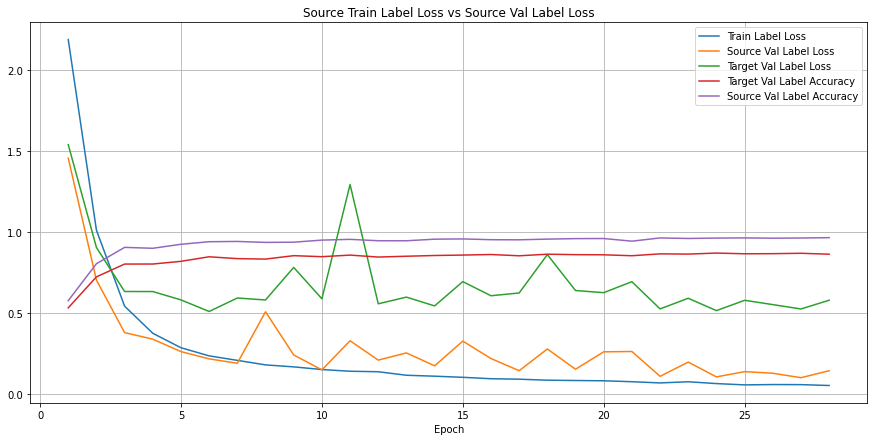

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

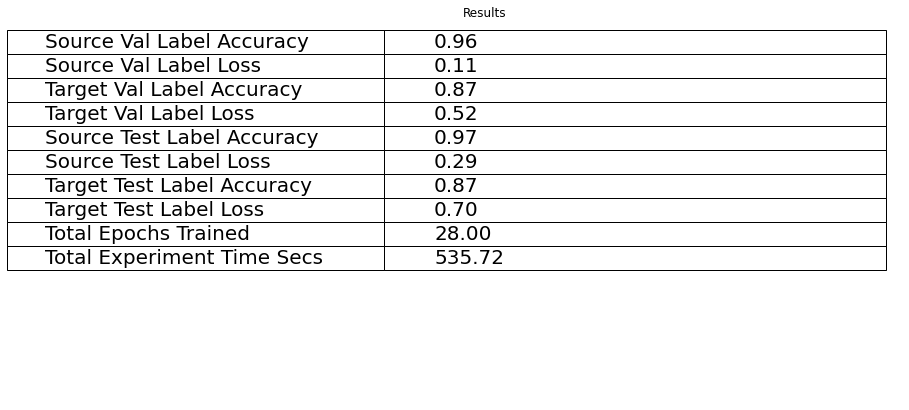

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

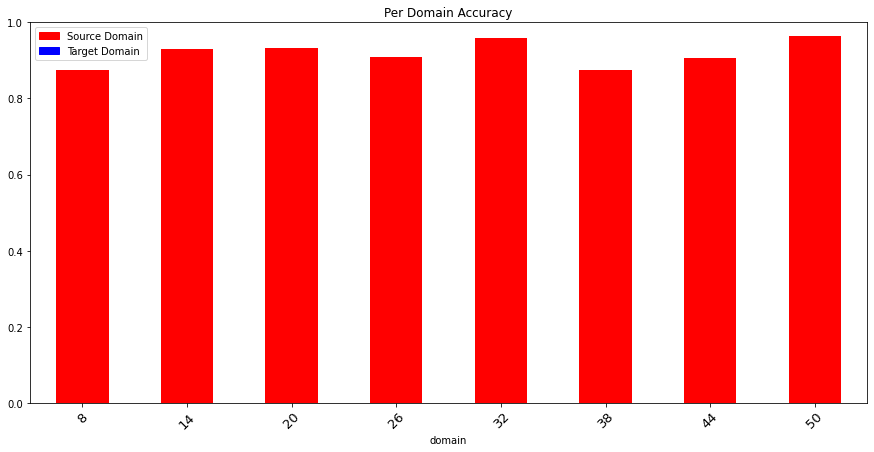

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9659375 Target Test Label Accuracy: 0.871796875
Source Val Label Accuracy: 0.964921875 Target Val Label Accuracy: 0.8723697916666666


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d